In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

#import lightgbm as lgb
import xgboost as xgb
import time
import datetime
#from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML
import json
#import altair as alt

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
#print(os.listdir("../input"))
print(os.listdir("champs-scalar-coupling"))

['scalar_coupling_contributions.csv', 'mulliken_charges.csv', 'structures.csv', 'test.csv', 'structures.zip', 'train.csv', 'magnetic_shielding_tensors.csv', 'dipole_moments.csv', 'sample_submission.csv', 'potential_energy.csv']


In [45]:
train = pd.read_csv('champs-scalar-coupling/train.csv')
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.807599999999994
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.257000000000000
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.254799999999999
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.254300000000001
4,4,dsgdb9nsd_000001,2,0,1JHC,84.807400000000001


In [4]:
test = pd.read_csv('champs-scalar-coupling/test.csv')
test.head()

,id,molecule_name,atom_index_0,atom_index_1,type
0,4658147,dsgdb9nsd_000004,2,0,2JHC
1,4658148,dsgdb9nsd_000004,2,1,1JHC
2,4658149,dsgdb9nsd_000004,2,3,3JHH
3,4658150,dsgdb9nsd_000004,3,0,1JHC
4,4658151,dsgdb9nsd_000004,3,1,2JHC


In [5]:
print('Train shape: {}'.format(train.shape))
print("")
print('Unique molecules:')
print(train.molecule_name.nunique())
print("")
print(train.info())
print("")
print('Types of atoms couples:', train.type.value_counts())
print("")
print('Number of atom couples types',train.type.nunique())

Train shape: (4658147, 6)

Unique molecules:
85003

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4658147 entries, 0 to 4658146
Data columns (total 6 columns):
id                          int64
molecule_name               object
atom_index_0                int64
atom_index_1                int64
type                        object
scalar_coupling_constant    float64
dtypes: float64(1), int64(3), object(2)
memory usage: 213.2+ MB
None

Types of atoms couples: 3JHC    1510379
2JHC    1140674
1JHC     709416
3JHH     590611
2JHH     378036
3JHN     166415
2JHN     119253
1JHN      43363
Name: type, dtype: int64

Number of atom couples types 8


### Заметки:
На расщепление (соответственно, и на константу расщепления) очень сильно влияют соседи самих атомов = остальные атомы
<br> в type зашифрованы следующие данные:
<br>первая цифра - как далеко находятся атом
<br>буква J - просто обозначение константы
<br>последние две буквы - взаимодействующие атомы в паре

In [6]:
mol = train.groupby(['molecule_name','type'])['atom_index_0'].count().unstack().fillna(0).reset_index()
mol.head(10)

type,molecule_name,1JHC,1JHN,2JHC,2JHH,2JHN,3JHC,3JHH,3JHN
0,dsgdb9nsd_000001,4.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0
1,dsgdb9nsd_000002,0.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0
2,dsgdb9nsd_000003,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,dsgdb9nsd_000005,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,dsgdb9nsd_000007,6.0,0.0,6.0,6.0,0.0,0.0,9.0,0.0
5,dsgdb9nsd_000008,3.0,0.0,1.0,3.0,0.0,0.0,3.0,0.0
6,dsgdb9nsd_000009,4.0,0.0,4.0,3.0,0.0,4.0,0.0,0.0
7,dsgdb9nsd_000010,3.0,0.0,3.0,3.0,0.0,0.0,0.0,3.0
8,dsgdb9nsd_000011,4.0,0.0,4.0,3.0,0.0,0.0,3.0,0.0
9,dsgdb9nsd_000012,1.0,2.0,2.0,1.0,1.0,0.0,2.0,0.0


dsgdb9nsd_000001:  CH4   Methane 
<br> dsgdb9nsd_000002:  NH3  Ammonia
<br> dsgdb9nsd_000003:  H2O  Water :-)
<br> dsgdb9nsd_000005:  HCN  Hydrogen cyanide (aka the infamous zyklon B) contains a triple 3CC bond
<br> dsgdb9nsd_000007:  C2H6    Ethane
<br> dsgdb9nsd_000008:  CH3OH  Methanol
<br> dsgdb9nsd_000009:  C3H4  Propyne contains a triple 3CC bond
<br> dsgdb9nsd_000010:  CH3CN  Acetonitrile
<br> dsgdb9nsd_000011:  CH3CHO  Ethanal or Acetaldehyde
<br> dsgdb9nsd_000012:  HCONH2  Formamide or Methanamid

In [48]:
train_join=pd.merge(train, mol, on='molecule_name')
train_join.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,...,y_1,z_1,1JHC,1JHN,2JHC,2JHH,2JHN,3JHC,3JHH,3JHN
0,0,dsgdb9nsd_000001,1,0,1JHC,84.807599999999994,H,0.002150416,-0.0060313176,0.0019761204,...,1.085804158,0.0080009958,4.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.257000000000000,H,0.002150416,-0.0060313176,0.0019761204,...,1.463751162,0.0002765748,4.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.254799999999999,H,0.002150416,-0.0060313176,0.0019761204,...,1.447526614,-0.8766437152,4.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.254300000000001,H,0.002150416,-0.0060313176,0.0019761204,...,1.437932644,0.9063972942,4.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0
4,4,dsgdb9nsd_000001,2,0,1JHC,84.807400000000001,H,1.011730843,1.4637511620,0.0002765748,...,1.085804158,0.0080009958,4.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0


In [97]:
train.type.value_counts()

3JHC    1510379
2JHC    1140674
1JHC     709416
3JHH     590611
2JHH     378036
3JHN     166415
2JHN     119253
1JHN      43363
Name: type, dtype: int64

In [8]:
structures = pd.read_csv('champs-scalar-coupling/structures.csv')
structures.head()

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.0126981359,1.0858041580,0.0080009958
1,dsgdb9nsd_000001,1,H,0.0021504160,-0.0060313176,0.0019761204
2,dsgdb9nsd_000001,2,H,1.0117308430,1.4637511620,0.0002765748
3,dsgdb9nsd_000001,3,H,-0.5408150690,1.4475266140,-0.8766437152
4,dsgdb9nsd_000001,4,H,-0.5238136345,1.4379326440,0.9063972942


In [ ]:
print('Unique molecules in structures:')
print(structures.molecule_name.nunique())
print("")
print('Unique molecules in train set:')
print(train.molecule_name.nunique())
print("")
print('Unique molecules in test set:')
print(test.molecule_name.nunique())

In [9]:
structures.atom.value_counts()

H    1208387
C     831726
O     183187
N     132361
F       2996
Name: atom, dtype: int64

In [10]:
structures[structures.atom=='F'].molecule_name.unique()

array(['dsgdb9nsd_000826', 'dsgdb9nsd_000828', 'dsgdb9nsd_000829', ...,
       'dsgdb9nsd_133809', 'dsgdb9nsd_133810', 'dsgdb9nsd_133811'],
      dtype=object)

In [59]:
mol_names = structures.molecule_name.unique()
print(len(mol_names))
print(mol_names[:10])

130775
['dsgdb9nsd_000001' 'dsgdb9nsd_000002' 'dsgdb9nsd_000003'
 'dsgdb9nsd_000004' 'dsgdb9nsd_000005' 'dsgdb9nsd_000007'
 'dsgdb9nsd_000008' 'dsgdb9nsd_000009' 'dsgdb9nsd_000010'
 'dsgdb9nsd_000011']


### Small DataFrame for ideas testing

In [ ]:
В таблице нет пар взаимодействий со фтором и кислородом!!! А они очень важны
Надо добавить расстояние от одного из атомов до ближайшего/всех атома фтора, азота или кислорода - можно прямо в таблицу structures,
а потом сделать merge
рассчитать различные виды расстояний

For a line, it  is a plunge and not a dip (for 3D planes)

It is an elementary problem in analytic geometry:

The distance = SQRT((x2 –x1)2+(y2 –y1)2+(z2 –z1)2)
The plunge = arcsin ((z2 – z1) / distance)
The azimuth = arctan((x2 –x1)/(y2 –y1)) (always in two dimensions)

The value θ returned will be in the range of ±90° and must be corrected to give the true azimuth over the range of 0 to 360°

You can also use the direction cosines of the line (the slopes on the xy , xz and yz planes)

In [73]:
s=structures.loc[:100].copy()
s.set_index('molecule_name', inplace=True)
s.head()#.groupby(['molecule_name','atom'])[['x']].diff()

,atom_index,atom,x,y,z
molecule_name,,,,,
dsgdb9nsd_000001,0,C,-0.0126981359,1.0858041580,0.0080009958
dsgdb9nsd_000001,1,H,0.0021504160,-0.0060313176,0.0019761204
dsgdb9nsd_000001,2,H,1.0117308430,1.4637511620,0.0002765748
dsgdb9nsd_000001,3,H,-0.5408150690,1.4475266140,-0.8766437152
dsgdb9nsd_000001,4,H,-0.5238136345,1.4379326440,0.9063972942


In [107]:
s['dif_x']=s['x'].diff()
s.head()

,atom_index,atom,x,y,z,C,dif_x
molecule_name,,,,,,,
dsgdb9nsd_000001,0,C,-0.0126981359,1.0858041580,0.0080009958,0,NaN
dsgdb9nsd_000001,1,H,0.0021504160,-0.0060313176,0.0019761204,0,0.0148485519
dsgdb9nsd_000001,2,H,1.0117308430,1.4637511620,0.0002765748,0,1.0095804270
dsgdb9nsd_000001,3,H,-0.5408150690,1.4475266140,-0.8766437152,0,-1.5525459120
dsgdb9nsd_000001,4,H,-0.5238136345,1.4379326440,0.9063972942,0,0.0170014345


In [118]:
s.reset_index(inplace=True)

In [121]:
s['x'][2]-s['x'][1]

1.009580427

In [232]:
ss=structures[structures.molecule_name=='dsgdb9nsd_133810'].copy()
ss

,molecule_name,atom_index,atom,x,y,z
2358071,dsgdb9nsd_133810,0,C,-0.1076533768,1.5404375190,0.0123341524
2358072,dsgdb9nsd_133810,1,C,-0.0170675081,0.0243149889,0.0021187638
2358073,dsgdb9nsd_133810,2,O,-1.3296582720,-0.5060470354,0.0121864991
2358074,dsgdb9nsd_133810,3,C,-1.3570969100,-1.9129858850,0.0041569776
2358075,dsgdb9nsd_133810,4,C,-2.8206724770,-2.3428701150,0.0161218089
2358076,dsgdb9nsd_133810,5,C,-2.9856221850,-3.8458232640,0.0093675362
2358077,dsgdb9nsd_133810,6,F,-2.4085990070,-4.4161608280,1.0820124390
2358078,dsgdb9nsd_133810,7,F,-4.2805210830,-4.1940788800,0.0197232656
2358079,dsgdb9nsd_133810,8,F,-2.4291013780,-4.4041989830,-1.0802789500
2358080,dsgdb9nsd_133810,9,H,0.8937450834,1.9808066880,0.0048872125


In [233]:
ss.to_csv('one.csv')

In [183]:
ss['all']=list(zip(ss.x, ss.y, ss.z))
ss['F1']=list(zip(ss.x_F1, ss.y_F1, ss.z_F1))
ss

,molecule_name,atom_index,atom,x,y,z,x_F1,y_F1,z_F1,x_F2,y_F2,z_F2,x_F3,y_F3,z_F3,all,F1
2358071,dsgdb9nsd_133810,0,C,-0.1076533768,1.5404375190,0.0123341524,-2.408599007,-4.416160828,1.082012439,-4.280521083,-4.19407888,0.0197232656,-2.429101378,-4.404198983,-1.08027895,"(-0.10765337679999999, 1.5404375190000001, 0.0...","(-2.408599007, -4.416160828, 1.082012439)"
2358072,dsgdb9nsd_133810,1,C,-0.0170675081,0.0243149889,0.0021187638,-2.408599007,-4.416160828,1.082012439,-4.280521083,-4.19407888,0.0197232656,-2.429101378,-4.404198983,-1.08027895,"(-0.0170675081, 0.0243149889, 0.0021187638)","(-2.408599007, -4.416160828, 1.082012439)"
2358073,dsgdb9nsd_133810,2,O,-1.3296582720,-0.5060470354,0.0121864991,-2.408599007,-4.416160828,1.082012439,-4.280521083,-4.19407888,0.0197232656,-2.429101378,-4.404198983,-1.08027895,"(-1.329658272, -0.5060470354, 0.0121864991)","(-2.408599007, -4.416160828, 1.082012439)"
2358074,dsgdb9nsd_133810,3,C,-1.3570969100,-1.9129858850,0.0041569776,-2.408599007,-4.416160828,1.082012439,-4.280521083,-4.19407888,0.0197232656,-2.429101378,-4.404198983,-1.08027895,"(-1.35709691, -1.912985885, 0.0041569776)","(-2.408599007, -4.416160828, 1.082012439)"
2358075,dsgdb9nsd_133810,4,C,-2.8206724770,-2.3428701150,0.0161218089,-2.408599007,-4.416160828,1.082012439,-4.280521083,-4.19407888,0.0197232656,-2.429101378,-4.404198983,-1.08027895,"(-2.820672477, -2.342870115, 0.0161218089)","(-2.408599007, -4.416160828, 1.082012439)"
2358076,dsgdb9nsd_133810,5,C,-2.9856221850,-3.8458232640,0.0093675362,-2.408599007,-4.416160828,1.082012439,-4.280521083,-4.19407888,0.0197232656,-2.429101378,-4.404198983,-1.08027895,"(-2.985622185, -3.845823264, 0.0093675362)","(-2.408599007, -4.416160828, 1.082012439)"
2358077,dsgdb9nsd_133810,6,F,-2.4085990070,-4.4161608280,1.0820124390,-2.408599007,-4.416160828,1.082012439,-4.280521083,-4.19407888,0.0197232656,-2.429101378,-4.404198983,-1.08027895,"(-2.408599007, -4.416160828, 1.082012439)","(-2.408599007, -4.416160828, 1.082012439)"
2358078,dsgdb9nsd_133810,7,F,-4.2805210830,-4.1940788800,0.0197232656,-2.408599007,-4.416160828,1.082012439,-4.280521083,-4.19407888,0.0197232656,-2.429101378,-4.404198983,-1.08027895,"(-4.280521083, -4.19407888, 0.0197232656)","(-2.408599007, -4.416160828, 1.082012439)"
2358079,dsgdb9nsd_133810,8,F,-2.4291013780,-4.4041989830,-1.0802789500,-2.408599007,-4.416160828,1.082012439,-4.280521083,-4.19407888,0.0197232656,-2.429101378,-4.404198983,-1.08027895,"(-2.429101378, -4.404198983, -1.08027895)","(-2.408599007, -4.416160828, 1.082012439)"
2358080,dsgdb9nsd_133810,9,H,0.8937450834,1.9808066880,0.0048872125,-2.408599007,-4.416160828,1.082012439,-4.280521083,-4.19407888,0.0197232656,-2.429101378,-4.404198983,-1.08027895,"(0.8937450834, 1.9808066880000001, 0.0048872125)","(-2.408599007, -4.416160828, 1.082012439)"


In [209]:
from scipy.spatial import distance
distance.euclidean(ss['all'].values[0],ss['F1'].values[0])

6.4745367631548065

In [214]:
np.linalg.norm(ss[['x', 'y']].values-ss[['x_F1', 'y_F1']].values,2,0)

array([ 7.63804872, 16.00968646])

In [186]:
from scipy.spatial import distance
a = (1, 2, 3)
b = (4, 5, 6)
dst = distance.euclidean(a, b)
dst

5.196152422706632

In [219]:
# Generate fake Pandas data frame
a = pd.Series(np.random.normal(1, 0.1, 5))
df = pd.DataFrame(a, columns=['a'])
df['b'] = pd.Series(np.random.normal(2, 0.1, 5))
df['c'] = pd.Series(np.random.normal(3, 0.1, 5))
import scipy
dist = scipy.spatial.distance.pdist(df, metric='euclidean')
dist

array([0.15058842, 0.24679163, 0.05669622, 0.27023   , 0.32239011,
       0.18168526, 0.24164633, 0.19230112, 0.26622641, 0.24802527])

In [221]:
# Массив с шагом 1 на парные расстояния в квадратную матричную форму
d_matrix = scipy.spatial.distance.squareform(dist)
d_matrix

array([[0.        , 0.15058842, 0.24679163, 0.05669622, 0.27023   ],
       [0.15058842, 0.        , 0.32239011, 0.18168526, 0.24164633],
       [0.24679163, 0.32239011, 0.        , 0.19230112, 0.26622641],
       [0.05669622, 0.18168526, 0.19230112, 0.        , 0.24802527],
       [0.27023   , 0.24164633, 0.26622641, 0.24802527, 0.        ]])

In [231]:
# cityblock -- the Manhattan distance =  модуль разности
# cdist(ss[['x', 'x_F1']], ss[['y', 'y_F1']], metric='euclidean')

scipy.spatial.distance.pdist(ss[['x', 'x_F1']], metric='euclidean')

array([0.09058587, 1.2220049 , 1.24944353, 2.7130191 , 2.87796881,
       2.30094563, 4.17286771, 2.321448  , 1.00139846, 0.54376924,
       0.52580688, 0.6327506 , 0.65073976, 0.74516053, 0.72758687,
       3.21137115, 3.22878666, 1.31259076, 1.3400294 , 2.80360497,
       2.96855468, 2.3915315 , 4.26345357, 2.41203387, 0.91081259,
       0.6343551 , 0.61639275, 0.54216473, 0.5601539 , 0.8357464 ,
       0.81817274, 3.30195702, 3.31937253, 0.02743864, 1.4910142 ,
       1.65596391, 1.07894073, 2.95086281, 1.09944311, 2.22340336,
       0.67823566, 0.69619801, 1.85475549, 1.87274466, 0.47684437,
       0.49441803, 1.98936626, 2.00678177, 1.46357557, 1.62852527,
       1.0515021 , 2.92342417, 1.07200447, 2.25084199, 0.7056743 ,
       0.72363665, 1.88219413, 1.9001833 , 0.50428301, 0.52185667,
       1.96192762, 1.97934313, 0.16494971, 0.41207347, 1.45984861,
       0.3915711 , 3.71441756, 2.16924986, 2.18721222, 3.3457697 ,
       3.36375886, 1.96785857, 1.98543223, 0.49835205, 0.51576

In [194]:
ss['all'].values[0]

(-0.10765337679999999, 1.5404375190000001, 0.0123341524)

In [197]:
distance.euclidean(ss[['all', 'F1']])

TypeError: euclidean() missing 1 required positional argument: 'v'

In [ ]:
http://qaru.site/questions/27481/how-can-the-euclidean-distance-be-calculated-with-numpy

In [203]:
np.linalg.norm(ss.x.values, ss.x_F1.values, ord=2, axis=0)

TypeError: norm() got multiple values for argument 'ord'

In [178]:
fs= ss[['x','y']].values[0].reshape(1,2)
fs

array([[-0.10765338,  1.54043752]])

In [175]:
ff[0]

array([-2.40859901, -4.41616083])

In [161]:
np.sqrt((fs[0][0]-ff[0][0])**2)

2.3009456301999998

In [179]:
import scipy.spatial
D2 = scipy.spatial.distance.cdist(fs.reshape(1,2),ff[0].reshape(1,2),'euclidean')
D2

array([[6.38556299]])

In [166]:
from scipy.spatial.distance import cdist
d=cdist(fs,ff)
d

array([[6.47453676, 7.09207712, 6.47469129],
       [5.15785021, 5.99768231, 5.15763785],
       [4.19495298, 4.72326445, 4.19497849]])

In [ ]:
# Найти для всех атомов все виды расстояний до атомов фтора
# Расположить эти расстояния по возрастанию для каждого атома
kd_tree

Molecular Sets (MOSES): A Benchmarking Platform for Molecular Generation Models
Benjamin Sanchez-Lengeling
scipy distance matrix

In [127]:
n_f=(ss['atom']=='F').sum()
n_f

3

In [130]:
indx = ss[ss['atom']=='F'].index
indx

Int64Index([2358077, 2358078, 2358079], dtype='int64')

In [137]:
f=[]
for n, ind  in enumerate(indx):
    f.append([ss.loc[indx[n]]['x'],ss.loc[indx[n]]['y'],ss.loc[indx[n]]['z'] ])
f

[[-2.408599007, -4.416160828, 1.082012439],
 [-4.280521083, -4.19407888, 0.0197232656],
 [-2.429101378, -4.404198983, -1.08027895]]

In [172]:
ff=np.zeros((n_f,2))
for n, ind  in enumerate(indx):
    ff[n,0]=ss.loc[indx[n]]['x']
    ff[n,1]=ss.loc[indx[n]]['y']
    #ff[n,2]=ss.loc[indx[n]]['z']
ff

array([[-2.40859901, -4.41616083],
       [-4.28052108, -4.19407888],
       [-2.42910138, -4.40419898]])

In [135]:
for n, ind  in enumerate(indx):
    ss['x_F'+str(n+1)]=ss.loc[indx[n]]['x']
    ss['y_F'+str(n+1)]=ss.loc[indx[n]]['y']
    ss['z_F'+str(n+1)]=ss.loc[indx[n]]['z']

In [136]:
ss

,molecule_name,atom_index,atom,x,y,z,x_F1,y_F1,z_F1,x_F2,y_F2,z_F2,x_F3,y_F3,z_F3
2358071,dsgdb9nsd_133810,0,C,-0.1076533768,1.5404375190,0.0123341524,-2.408599007,-4.416160828,1.082012439,-4.280521083,-4.19407888,0.0197232656,-2.429101378,-4.404198983,-1.08027895
2358072,dsgdb9nsd_133810,1,C,-0.0170675081,0.0243149889,0.0021187638,-2.408599007,-4.416160828,1.082012439,-4.280521083,-4.19407888,0.0197232656,-2.429101378,-4.404198983,-1.08027895
2358073,dsgdb9nsd_133810,2,O,-1.3296582720,-0.5060470354,0.0121864991,-2.408599007,-4.416160828,1.082012439,-4.280521083,-4.19407888,0.0197232656,-2.429101378,-4.404198983,-1.08027895
2358074,dsgdb9nsd_133810,3,C,-1.3570969100,-1.9129858850,0.0041569776,-2.408599007,-4.416160828,1.082012439,-4.280521083,-4.19407888,0.0197232656,-2.429101378,-4.404198983,-1.08027895
2358075,dsgdb9nsd_133810,4,C,-2.8206724770,-2.3428701150,0.0161218089,-2.408599007,-4.416160828,1.082012439,-4.280521083,-4.19407888,0.0197232656,-2.429101378,-4.404198983,-1.08027895
2358076,dsgdb9nsd_133810,5,C,-2.9856221850,-3.8458232640,0.0093675362,-2.408599007,-4.416160828,1.082012439,-4.280521083,-4.19407888,0.0197232656,-2.429101378,-4.404198983,-1.08027895
2358077,dsgdb9nsd_133810,6,F,-2.4085990070,-4.4161608280,1.0820124390,-2.408599007,-4.416160828,1.082012439,-4.280521083,-4.19407888,0.0197232656,-2.429101378,-4.404198983,-1.08027895
2358078,dsgdb9nsd_133810,7,F,-4.2805210830,-4.1940788800,0.0197232656,-2.408599007,-4.416160828,1.082012439,-4.280521083,-4.19407888,0.0197232656,-2.429101378,-4.404198983,-1.08027895
2358079,dsgdb9nsd_133810,8,F,-2.4291013780,-4.4041989830,-1.0802789500,-2.408599007,-4.416160828,1.082012439,-4.280521083,-4.19407888,0.0197232656,-2.429101378,-4.404198983,-1.08027895
2358080,dsgdb9nsd_133810,9,H,0.8937450834,1.9808066880,0.0048872125,-2.408599007,-4.416160828,1.082012439,-4.280521083,-4.19407888,0.0197232656,-2.429101378,-4.404198983,-1.08027895


In [ ]:
for n in n_f:
    ss['x_F'+str(n)]=

In [ ]:
import math
s['dist']=

In [ ]:
import math
 x1,y1,z1 = 5.0,6.7,1.5
 x2,y2,z2 = 4.0,1.2,1.6
 distance = math.sqrt((x2-x1)**2+(y2-y1)**2+(z2 -z1)**2)
 print distance
 5.5910642993977451
 plunge = math.degrees(math.asin((z2-z1)/distance)
 print plunge
 1.0248287567800018 # the resulting dip_plunge is positive downward if z2 > z1
 azimuth = math.degrees(math.atan2((x2-x1),(y2-y1)))
 print azimuth
 -169.69515353123398 

In [85]:
s['C']=100 #Расстояние до тех атомов, которых нет в молекуле, надо сделать очень большим
for molecule in s.index:
    if (s.loc[molecule]['atom']=='C').any()==True:
        s.loc[molecule]['C']=0
s.head()

,atom_index,atom,x,y,z,C
molecule_name,,,,,,
dsgdb9nsd_000001,0,C,-0.0126981359,1.0858041580,0.0080009958,0
dsgdb9nsd_000001,1,H,0.0021504160,-0.0060313176,0.0019761204,0
dsgdb9nsd_000001,2,H,1.0117308430,1.4637511620,0.0002765748,0
dsgdb9nsd_000001,3,H,-0.5408150690,1.4475266140,-0.8766437152,0
dsgdb9nsd_000001,4,H,-0.5238136345,1.4379326440,0.9063972942,0


In [87]:
structures.atom.value_counts()

H    1208387
C     831726
O     183187
N     132361
F       2996
Name: atom, dtype: int64

In [31]:
struct = structures.groupby(['molecule_name','atom'])['atom_index'].count().unstack().fillna(0).reset_index()
struct['total']=structures.groupby('molecule_name')['atom'].count().values
struct.head(10)

atom,molecule_name,C,F,H,N,O
0,dsgdb9nsd_000001,1.0,0.0,4.0,0.0,0.0
1,dsgdb9nsd_000002,0.0,0.0,3.0,1.0,0.0
2,dsgdb9nsd_000003,0.0,0.0,2.0,0.0,1.0
3,dsgdb9nsd_000004,2.0,0.0,2.0,0.0,0.0
4,dsgdb9nsd_000005,1.0,0.0,1.0,1.0,0.0
5,dsgdb9nsd_000007,2.0,0.0,6.0,0.0,0.0
6,dsgdb9nsd_000008,1.0,0.0,4.0,0.0,1.0
7,dsgdb9nsd_000009,3.0,0.0,4.0,0.0,0.0
8,dsgdb9nsd_000010,2.0,0.0,3.0,1.0,0.0
9,dsgdb9nsd_000011,2.0,0.0,4.0,0.0,1.0


In [96]:
struct.head()

atom,molecule_name,C,F,H,N,O,total
0,dsgdb9nsd_000001,1.0,0.0,4.0,0.0,0.0,5
1,dsgdb9nsd_000002,0.0,0.0,3.0,1.0,0.0,4
2,dsgdb9nsd_000003,0.0,0.0,2.0,0.0,1.0,3
3,dsgdb9nsd_000004,2.0,0.0,2.0,0.0,0.0,4
4,dsgdb9nsd_000005,1.0,0.0,1.0,1.0,0.0,3


In [95]:
print("Max number of F:", struct.F.max())
print("")
print("Max number of N:", struct.N.max())
print("")
print("Max number of O:", struct.O.max())

Max number of F: 6.0

Max number of N: 7.0

Max number of O: 5.0


In [ ]:
train_join=pd.merge(train_join, struct, on='molecule_name')
train_join.head()

In [ ]:
В таблице нет пар взаимодействий со фтором и кислородом!!! А они очень важны
Надо добавить расстояние от одного из атомов до ближайшего атома фтора или кислорода - можно прямо в таблицу structures,
а потом сделать merge

Увеличить таблицу structures - расстояние до каждого из атомов F, N, O,
а потом сделать merge

Расстояние можно сделать в шкале логарифмов!

Разные виды расстояний


In Python:

 import math
 x1,y1,z1 = 5.0,6.7,1.5
 x2,y2,z2 = 4.0,1.2,1.6
 distance = math.sqrt((x2-x1)**2+(y2-y1)**2+(z2 -z1)**2)
 print distance
 5.5910642993977451
 plunge = math.degrees(math.asin((z2-z1)/distance)
 print plunge
 1.0248287567800018 # the resulting dip_plunge is positive downward if z2 > z1
 azimuth = math.degrees(math.atan2((x2-x1),(y2-y1)))
 print azimuth
 -169.69515353123398 # = 360 + azimuth = 190.30484646876602 or  180+ azimuth = 10.304846468766016 over the range of 0 to 360°

With the direction cosines:

cosalpha =(x2-x1)/distance
cosbeta=(y2-y1)/distance
cosgamma= (z2-z1)/distance
plunge = math.degrees(math.asin(cosgamma))
print plunge
1.0248287567800018 # the resulting dip_plunge is positive downward if z2 > z1
azimuth = math.degrees(math.atan2(cosa, cosb))
print azimuth                     

Одинарные/двойные и тройные связи - хорошая идея

Разделение на hold-out и validation set  по молекулам, но чтобы все классы присутствовали 
                       (молекулы со фтором тоже были)
Не забыть в конце сделать  Scaling
Сами константы тоже можно обрабатывать через log

In [ ]:
Собрать hold-out и validation set вручную
но чтобы сохранить пропорции между типами расщеплений

In [ ]:
molecules = train.pop('molecule_name')
test = test.drop('molecule_name', axis=1)

y = train.pop('scalar_coupling_constant')

# Label Encoding
for f in ['type', 'atom_0', 'atom_1']:
    lbl = LabelEncoder()
    lbl.fit(list(train[f].values) + list(train[f].values))
    train[f] = lbl.transform(list(train[f].values))
    test[f] = lbl.transform(list(test[f].values))

In [ ]:
yoof = np.zeros(len(train))
yhat = np.zeros(len(test))

n_splits = 3
gkf = GroupKFold(n_splits=n_splits) # we're going to split folds by molecules

fold = 0
for in_index, oof_index in gkf.split(train, y, groups=molecules):
    fold += 1
    print(f'fold {fold} of {n_splits}')
    X_in, X_oof = train.values[in_index], train.values[oof_index]
    y_in, y_oof = y.values[in_index], y.values[oof_index]
    reg = RandomForestRegressor(n_estimators=250,
                                max_depth=9,
                                min_samples_leaf=3,
                                n_jobs=-1)
    reg.fit(X_in, y_in)
    yoof[oof_index] = reg.predict(X_oof)
    yhat += reg.predict(test)

yhat /= n_splits

In [99]:
import random

# Select a molecule
random_molecule = random.choice(structures['molecule_name'].unique())
molecule = structures[structures['molecule_name'] == random_molecule]
molecule

,molecule_name,atom_index,atom,x,y,z
2208263,dsgdb9nsd_123163,0,C,-0.3451339484,1.6061300170,0.0492539186
2208264,dsgdb9nsd_123163,1,C,-0.2300207403,0.0791219391,0.0508608848
2208265,dsgdb9nsd_123163,2,C,-1.4642353630,-0.5873961686,-0.5632471521
2208266,dsgdb9nsd_123163,3,O,-1.3660248220,-1.9938832230,-0.6763257706
2208267,dsgdb9nsd_123163,4,C,-1.5530096580,-2.7022869760,0.5303778121
2208268,dsgdb9nsd_123163,5,C,-1.5909749670,-4.1879824850,0.1909482413
2208269,dsgdb9nsd_123163,6,N,-1.7459995280,-4.9769302880,1.4058478980
2208270,dsgdb9nsd_123163,7,C,-3.1167473830,-5.2815696580,1.8084252040
2208271,dsgdb9nsd_123163,8,C,-2.2400004620,-6.3366523360,1.2308964250
2208272,dsgdb9nsd_123163,9,H,0.5434314394,2.0712537200,0.4857887363


In [235]:
structures['molecule_name'].unique()[:5]

array(['dsgdb9nsd_000001', 'dsgdb9nsd_000002', 'dsgdb9nsd_000003',
       'dsgdb9nsd_000004', 'dsgdb9nsd_000005'], dtype=object)

In [238]:
w = structures.set_index('molecule_name').loc[structures['molecule_name'].unique()[10:15]]
w.to_csv('five.csv')

In [ ]:
import random

# Select a molecule
random_molecule = random.choice(structures['molecule_name'].unique())
molecule = structures[structures['molecule_name'] == random_molecule]

In [100]:
# Get atomic coordinates
atoms = molecule.iloc[:, 3:].values
# Get atomic symbols
symbols = molecule.iloc[:, 2].values
print(symbols)

['C' 'C' 'C' 'O' 'C' 'C' 'N' 'C' 'C' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H'
 'H' 'H' 'H' 'H' 'H' 'H']


In [ ]:
#Visualisation
import ase
from ase import Atoms
import ase.visualize

system = Atoms(positions=atoms, symbols=symbols)

ase.visualize.view(system, viewer="x3d")

In [ ]:
def view(molecule):
    # Select a molecule
    mol = structures[structures['molecule_name'] == molecule]
    
    # Get atomic coordinates
    xcart = mol.iloc[:, 3:].values
    
    # Get atomic symbols
    symbols = mol.iloc[:, 2].values
    
    # Display molecule
    system = Atoms(positions=xcart, symbols=symbols)
    print('Molecule Name: %s.' %molecule)
    return ase.visualize.view(system, viewer="x3d")

random_molecule = random.choice(structures['molecule_name'].unique())
view(random_molecule)

In [ ]:
Собрать hold-out и validation set вручную

### Metric

In [102]:
def metric(df, preds):
    df["prediction"] = preds
    maes = []
    for t in df.type.unique():
        y_true = df[df.type==t].scalar_coupling_constant.values
        y_pred = df[df.type==t].prediction.values
        mae = np.log(metrics.mean_absolute_error(y_true, y_pred))
        maes.append(mae)
    return np.mean(maes)

In [103]:
metric(train, np.zeros(len(train)))

1.997412159590861

In [38]:
train_join[train_join.molecule_name == 'dsgdb9nsd_000826'][['atom_0','atom_1']]

,atom_0,atom_0,atom_1
16565,H,H,C
16566,H,H,C
16567,H,H,C


In [35]:
def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

In [36]:
%%time
train_join = map_atom_info(train_join, 0)
train_join = map_atom_info(train_join, 1)

CPU times: user 18.4 s, sys: 35.4 s, total: 53.8 s
Wall time: 1min 11s


In [15]:
train[train.atom_1=='N'].head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1
10,10,dsgdb9nsd_000002,1,0,1JHN,32.688899999999997,H,0.0172574639,0.0125452063,-0.0273771593,N,-0.0404260543,1.0241077530,0.0625637998
13,13,dsgdb9nsd_000002,2,0,1JHN,32.689100000000003,H,0.9157893661,1.3587451950,-0.0287577581,N,-0.0404260543,1.0241077530,0.0625637998
15,15,dsgdb9nsd_000002,3,0,1JHN,32.690500000000000,H,-0.5202777357,1.3435321260,-0.7755426124,N,-0.0404260543,1.0241077530,0.0625637998
18,18,dsgdb9nsd_000005,2,1,2JHN,5.182460000000000,H,-0.0278026991,2.1989492960,0.0141537903,N,0.0023107217,-0.0191585871,0.0019287305
73,73,dsgdb9nsd_000010,3,2,3JHN,0.880802000000000,H,1.0020294120,1.8608992680,0.0024540105,N,0.0176523530,-1.1445292600,-0.0042044500


In [16]:
train.atom_1.value_counts()

C    3360469
H     968647
N     329031
Name: atom_1, dtype: int64

In [29]:
train.atom_0.value_counts()

0    4658147
Name: atom_0, dtype: int64

In [17]:
train_p_0 = train[['x_0', 'y_0', 'z_0']].values
train_p_1 = train[['x_1', 'y_1', 'z_1']].values
test_p_0 = test[['x_0', 'y_0', 'z_0']].values
test_p_1 = test[['x_1', 'y_1', 'z_1']].values

train['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)
train['dist_x'] = (train['x_0'] - train['x_1']) ** 2
test['dist_x'] = (test['x_0'] - test['x_1']) ** 2
train['dist_y'] = (train['y_0'] - train['y_1']) ** 2
test['dist_y'] = (test['y_0'] - test['y_1']) ** 2
train['dist_z'] = (train['z_0'] - train['z_1']) ** 2
test['dist_z'] = (test['z_0'] - test['z_1']) ** 2

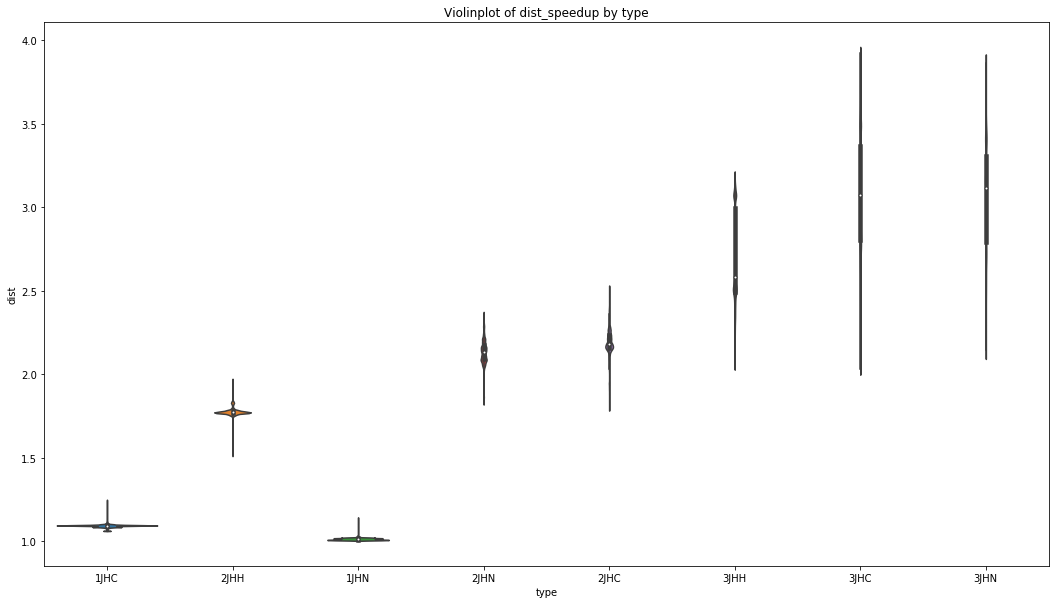

In [18]:
plt.figure(figsize=(18,10))
sns.violinplot(x='type', y='dist', data=train, split=True)
plt.title('Violinplot of dist_speedup by type');

In [19]:
#New features from type - J constant
train['type_0'] = train['type'].apply(lambda x: x[0])
test['type_0'] = test['type'].apply(lambda x: x[0])
train['type_1'] = train['type'].apply(lambda x: x[2:])
test['type_1'] = test['type'].apply(lambda x: x[2:])

### Features for distances

In [20]:
train = pd.concat([train, pd.get_dummies(train['type'])], axis=1)
test = pd.concat([test, pd.get_dummies(test['type'])], axis=1)

In [21]:
for f in ['atom_0', 'atom_1', 'type_0', 'type_1', 'type']:
    lbl = LabelEncoder()
    lbl.fit(list(train[f].values) + list(test[f].values))
    train[f] = lbl.transform(list(train[f].values))
    test[f] = lbl.transform(list(test[f].values))

In [22]:
X = train.drop(['id', 'molecule_name', 'scalar_coupling_constant'], axis=1)
y = train['scalar_coupling_constant']
X_test = test.drop(['id', 'molecule_name'], axis=1)

In [23]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

In [24]:
def count_others(x, df, atom_type):
    """Count the number of other couples types in molecule"""
    if atom_type in df.loc[x].index:
        n = df.loc[(x, atom_type)]
    else:
        n=0
    return n

In [25]:
atom_types_unique= train.type.value_counts()
atom_types= atom_types_unique.index
atom_types

Int64Index([5, 2, 0, 6, 3, 7, 4, 1], dtype='int64')

In [26]:
type_count=train.type.nunique()
type_count

8

In [27]:
types = []
counts = []
mins_0 = []
maxs_0 =[]
mins_1 = []
maxs_1 =[]
mins_J = []
maxs_J =[]
for i in range(type_count):
    types.append(atom_types[i])
    df=train[train['type']==atom_types[i]]
    counts.append(df.shape[0])
    mins_0.append(df['atom_index_0'].min())
    maxs_0.append(df['atom_index_0'].max())
    mins_1.append(df['atom_index_1'].min())
    maxs_1.append(df['atom_index_1'].max())
    mins_J.append(df['scalar_coupling_constant'].min())
    maxs_J.append(df['scalar_coupling_constant'].max())

In [28]:
df=pd.DataFrame({'types':types, 'counts':counts,
                 'mins_0': mins_0, 'maxs_0': maxs_0, 
                 'mins_1': mins_1,'maxs_1': maxs_1,
                 'mins_J': mins_J,'maxs_J': maxs_J})
df

,types,counts,mins_0,maxs_0,mins_1,maxs_1,mins_J,maxs_J
0,5,1510379,1,28,0,18,-18.582100000000001,76.043700000000001
1,2,1140674,0,28,0,17,-36.218600000000002,42.819200000000002
2,0,709416,1,28,0,18,66.600800000000007,204.879999999999995
3,6,590611,0,25,3,28,-3.020460000000000,17.484100000000002
4,3,378036,1,27,2,28,-35.176099999999998,11.854200000000001
5,7,166415,1,25,0,11,-3.172410000000000,10.971200000000000
6,4,119253,2,25,0,11,-2.620850000000000,17.743600000000001
7,1,43363,0,23,0,11,24.322199999999999,80.418700000000001
